In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random

np.random.seed(123)

In [2]:
OPT = -206220149 # PSIS-LOO for prior optimal on the test set

# Preprocessing code

In [3]:
DIR="RESULTS_BO/"

def extract_best_solutions(df): 
    """Calculates the best hyperparams until time t."""
    df.sort_values(by=["t", "train_loo"], inplace=True)
    best_train, best_test = [], []
    for i, (t, train_loo, test_loo) in enumerate(zip(df["t"], df["train_loo"], df["test_loo"])):
        if len(best_train)<=0: 
            best_train = [train_loo]
            best_test = [test_loo]
        else:
            if best_train[-1]<train_loo:
                best_train.append(train_loo)
                if np.isnan(test_loo): best_test.append(best_test[-1])
                else:                  best_test.append(test_loo)
            else:
                best_train.append(best_train[-1])
                best_test.append(best_test[-1])
    df["best_train"] = best_train
    df["best_test"] = best_test
    df["better_than_prior"] = np.array(df["best_test"]) > OPT
    return df


def load_csv(path, directory=DIR):
    COLUMNS = ["K","a","b","c","d","train_loo","test_loo","st","mt","et"]
    df = pd.read_csv(directory+path, header=None).rename(columns=dict(enumerate(COLUMNS)))
    start = df["st"].min()
    df["t"] = df["et"]-start
    
    df = extract_best_solutions(df)
    return df


def load_csvs(paths, requested_lifetime=5000, populate_numtimes=10, directory=DIR, verbose=False):
    """Returns list of BOs and list of BOs populated and extened randomly to requested time."""
    dfs0 = [load_csv(path,directory) for path in paths] 
    
    dfs = []
    for p, df0 in enumerate(dfs0):
        for i in range(populate_numtimes):
            
            df = df0.copy()                        
            while df["t"].max() < requested_lifetime:
                if verbose:
                    print("Extending %s. Current lifetime: %s (%i rows)." % \
                          (paths[p], df["t"].max(), len(df)))
                df1 = random.choice(dfs0).copy()
                df1["t"] = df1["t"] + df["t"].max() #shift time
                df = df.append(df1)  
                df = extract_best_solutions(df) #reevaluate best solution
            if verbose:
                print("%s. Final lifetime of %s is %s (%i rows)." % \
                      (i, paths[p], df["t"].max(), len(df)))
            dfs.append(df)
        
    return dfs0, dfs

In [4]:
def extract_lifetimes(dfs):
    return [df["t"].max() for df in dfs]


def extract_threshold_time(df):
    """Returns time when better than prior opt."""
    d = df[df["better_than_prior"]==True]["t"]
    return None if len(d)<=0 else d.min()


def extract_threshold_times(dfs):    
    return [extract_threshold_time(df) for df in dfs]  

    
def calc_fraction_above_threshold(threshold_times, lifetimes, max_time=10000, omit_crashed_at_time=True):
    threshold_times = np.array(threshold_times)
    lifetimes = np.array(lifetimes)
    threshold_times[threshold_times==None] = 10000000000

    times = np.arange(0, max_time, 10)
    fractions = []
    for t in times:
        valid_thresholds_times = threshold_times[ (lifetimes>t) | (threshold_times<t) ] 
        normalizer = len(valid_thresholds_times) if omit_crashed_at_time else len(threshold_times)
        above_threshold_fraction = np.sum(valid_thresholds_times<t)/normalizer
        #print(t, above_threshold_fraction)
        fractions.append(above_threshold_fraction)
    return times, np.array(fractions)

# Results

In [5]:
COLORS = ['yellow', 'teal', 'crimson',  'pink', "dodgerblue", 
          'mediumspringgreen', 'limegreen',  'violet', 'orange', "salmon"]

COLNO = 0 
    
def plot_df(df):
    global COLNO
    c = COLORS[COLNO%len(COLORS)]
    plt.plot(df["t"], df["best_test"], lw=2.5, color=c)
    plt.scatter(list(df["t"])[-1], list(df["best_test"])[-1], marker="x", s=90, color=c)
    COLNO += 1
        
def plt_csv(path):
    df = load_csv(path)
    plot_df(df)        
    return df

In [6]:
paths1 = ["bo_pmf_cfg3_100_bo_posterior.csv", "bo_pmf_cfg3_101_bo_posterior.csv", "bo_pmf_cfg3_102_bo_posterior.csv", 
"bo_pmf_cfg3_103_bo_posterior.csv", "bo_pmf_cfg3_104_bo_posterior.csv", "bo_pmf_cfg3_105_bo_posterior.csv", 
"bo_pmf_cfg3_106_bo_posterior.csv", "bo_pmf_cfg3_107_bo_posterior.csv", "bo_pmf_cfg3_108_bo_posterior.csv", 
"bo_pmf_cfg3_109_bo_posterior.csv", "bo_pmf_cfg3_110_bo_posterior.csv", "bo_pmf_cfg3_111_bo_posterior.csv", 
"bo_pmf_cfg3_112_bo_posterior.csv", "bo_pmf_cfg3_113_bo_posterior.csv", "bo_pmf_cfg3_114_bo_posterior.csv", 
"bo_pmf_cfg3_115_bo_posterior.csv", ]

paths2 = ["bo_pmf_cfg3_200_bo_posterior.csv", "bo_pmf_cfg3_201_bo_posterior.csv", 
"bo_pmf_cfg3_202_bo_posterior.csv", "bo_pmf_cfg3_203_bo_posterior.csv", "bo_pmf_cfg3_204_bo_posterior.csv", 
"bo_pmf_cfg3_205_bo_posterior.csv", "bo_pmf_cfg3_206_bo_posterior.csv", "bo_pmf_cfg3_207_bo_posterior.csv", 
"bo_pmf_cfg3_208_bo_posterior.csv", "bo_pmf_cfg3_209_bo_posterior.csv", "bo_pmf_cfg3_210_bo_posterior.csv", 
"bo_pmf_cfg3_211_bo_posterior.csv", "bo_pmf_cfg3_212_bo_posterior.csv", "bo_pmf_cfg3_213_bo_posterior.csv", 
"bo_pmf_cfg3_214_bo_posterior.csv", "bo_pmf_cfg3_215_bo_posterior.csv"]

paths3 = ["bo_pmf_cfg3_300_bo_posterior.csv", #interrupted part
"bo_pmf_cfg3_301_bo_posterior.csv", "bo_pmf_cfg3_302_bo_posterior.csv", "bo_pmf_cfg3_304_bo_posterior.csv", 
"bo_pmf_cfg3_308_bo_posterior.csv", "bo_pmf_cfg3_309_bo_posterior.csv", "bo_pmf_cfg3_312_bo_posterior.csv"]

In [13]:
np.random.seed(999)
dfs0, dfs = load_csvs(paths1+paths2, requested_lifetime=3600, populate_numtimes=1)
np.random.shuffle(dfs)

/home/anonymized/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


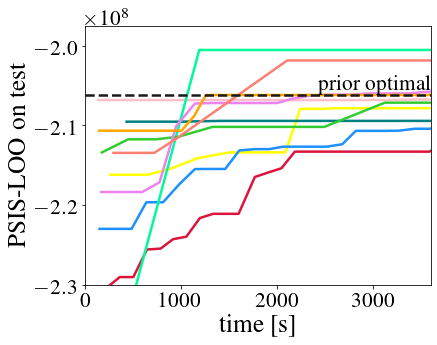

In [17]:
from aux_plt import  start_plotting
start_plotting(cmbright=False)

for df in dfs[:10]: plot_df(df)


#plt.ylim(-2.1*1e8, -2.02*1e8)
#plt.ylim(-2.15*1e8, -2.05*1e8)
plt.ylim(-2.3*1e8, -1.975*1e8)
#plt.xscale("log")
plt.xlim(0,3600)

plt.axhline(OPT, lw=2.5, color="k", ls="--")
x1, x2 = plt.xlim()
plt.text(x2,OPT,"prior optimal", ha="right", va="bottom")

plt.xlabel("time [s]")
plt.ylabel("PSIS-LOO on test")

plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.15)    
plt.savefig("bo.pdf")
plt.show()

In [9]:
dfs0, dfs = load_csvs(paths1+paths2, requested_lifetime=10000, populate_numtimes=10)

/home/anonymized/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


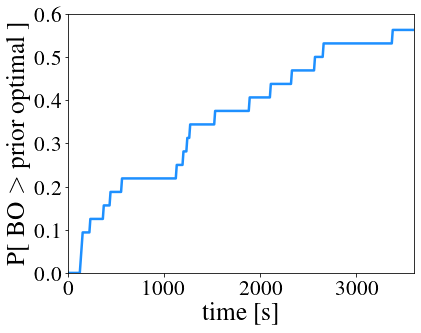

In [23]:
start_plotting(cmbright=False)

threshold_times = extract_threshold_times(dfs)
lifetimes = extract_lifetimes(dfs)
times, fractions = calc_fraction_above_threshold(threshold_times, lifetimes, omit_crashed_at_time=True)

plt.plot(times, fractions, lw=2.5, color="dodgerblue")
#plt.xscale("log")
plt.xlim(0,3600)
plt.ylabel(r"P[ BO $>$ prior optimal ]")
plt.ylim(0, 0.6)
plt.xlabel("time [s]")
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.15)    
plt.savefig("bo_fraction.pdf")
plt.show()